# Toxic comments detection
The adjective 'toxic' is the [word of the year 2018 by Oxford](https://languages.oup.com/word-of-the-year/2018/).
> The Oxford Word of the Year is a word or expression that is judged to reflect the ethos, mood, or preoccupations of the passing year, and have lasting potential as a term of cultural significance.
> 
>  
> 
> In 2018, toxic added many strings to its poisoned bow becoming an intoxicating descriptor for the year’s most talked about topics. It is the sheer scope of its application, as found by our research, that made toxic the stand-out choice for the Word of the Year title.

Toxic means: `extremely harsh, malicious, or harmful`.  
example: toxic sarcasm

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../jigsaw-toxic-comment-classification-challenge/"))
# print(os.listdir("../input/jigsaw-toxic-comment-classification-challenge"))

# Any results you write to the current directory are saved as output.

['test.csv.zip', 'test_labels.csv.zip', 'sample_submission.csv.zip', 'train.csv.zip']


In [16]:
# Load the dataset
train = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv.zip')
target = train['toxic']
test = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/test.csv.zip')

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.09584448302009764
Minimum accuracy: 0.9041555169799024


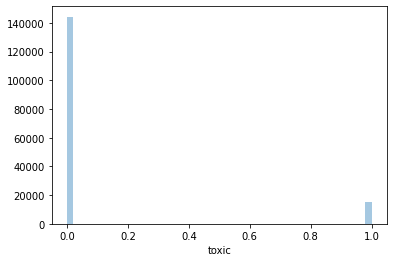

In [17]:
sns.distplot(target, kde=False)
print(target.mean())
print('Minimum accuracy:', max(target.mean(), 1 - target.mean()))

# TF-IDF

In [18]:
# define preprocessing function
import string

def preprocess(doc):
    # lowercasing
    doc = doc.lower()
    # remove punctuation and different kinds of whitespaces e.g. newlines and tabs
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # remove unneeded spaces
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [19]:
# Preprocessed text corpus
corpus = train['comment_text'].map(preprocess)
corpus.head(10)

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
5    congratulations from me as well use the tools ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense was offensive to yo...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(max_features=30000)
svd = TruncatedSVD(n_components=100)

X_tfidf = vectorizer.fit_transform(corpus)
print(X_tfidf.shape)
X_svd = svd.fit_transform(X_tfidf)
print(X_svd.shape)

(159571, 30000)
(159571, 100)


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
import warnings

def eval_on_trainset(X, y, model_names=None):
    models = {
        'SVM_rbf': SVC(C=100, kernel='rbf'),
        'SVM_linear': SVC(C=100, kernel='linear'),
        'Log regression': LogisticRegression(),
        'naive bayes': GaussianNB(),
        'random forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
    }
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    print('Dummy accuracy:', max(y.mean(), 1 - y.mean()))
    print()
    
    try:
        X = X.toarray()
    except:
        pass
    
    for name in model_names or sorted(models):
        model = models[name]
        with warnings.catch_warnings():
            scores_svc = cross_validate(model, X, y, cv=3, scoring=scoring)
        for sc in scoring:
            mean = scores_svc['test_' + sc].mean()
            std = scores_svc['test_' + sc].std()
            print(name, sc, '{:.03} +- {:.03}'.format(mean, std))
        print()

In [39]:
# Small part of tfidf, because of time and memory usage
%time eval_on_trainset(X_tfidf[:3000], target[:3000], ['Log regression', 'naive bayes', 'random forest'])

Dummy accuracy: 0.8976666666666666

Log regression accuracy 0.912 +- 0.00249
Log regression precision 1.0 +- 0.0
Log regression recall 0.143 +- 0.0275
Log regression f1 0.25 +- 0.0423
Log regression roc_auc 0.916 +- 0.0104

naive bayes accuracy 0.869 +- 0.013
naive bayes precision 0.336 +- 0.0486
naive bayes recall 0.267 +- 0.011
naive bayes f1 0.296 +- 0.0216
naive bayes roc_auc 0.602 +- 0.00869

random forest accuracy 0.914 +- 0.00236
random forest precision 1.0 +- 0.0
random forest recall 0.156 +- 0.0268
random forest f1 0.269 +- 0.0395
random forest roc_auc 0.901 +- 0.00838

CPU times: user 1min 7s, sys: 9.71 s, total: 1min 17s
Wall time: 59.2 s


In [40]:
# Part of data, because of time usage
%time eval_on_trainset(X_svd[:10000], target[:10000])

Dummy accuracy: 0.9029

KNN accuracy 0.912 +- 0.00246
KNN precision 0.572 +- 0.0171
KNN recall 0.38 +- 0.023
KNN f1 0.456 +- 0.0213
KNN roc_auc 0.781 +- 0.021

Log regression accuracy 0.924 +- 0.00124
Log regression precision 0.921 +- 0.0461
Log regression recall 0.236 +- 0.0201
Log regression f1 0.375 +- 0.023
Log regression roc_auc 0.914 +- 0.00381

SVM_linear accuracy 0.94 +- 0.000656
SVM_linear precision 0.873 +- 0.0272
SVM_linear recall 0.445 +- 0.0225
SVM_linear f1 0.589 +- 0.0145
SVM_linear roc_auc 0.915 +- 0.00697

SVM_rbf accuracy 0.925 +- 0.00294
SVM_rbf precision 0.64 +- 0.0226
SVM_rbf recall 0.533 +- 0.0182
SVM_rbf f1 0.581 +- 0.0137
SVM_rbf roc_auc 0.881 +- 0.00661

naive bayes accuracy 0.904 +- 0.000779
naive bayes precision 0.508 +- 0.00423
naive bayes recall 0.523 +- 0.0476
naive bayes f1 0.514 +- 0.0214
naive bayes roc_auc 0.845 +- 0.00929

random forest accuracy 0.922 +- 0.00246
random forest precision 0.948 +- 0.0158
random forest recall 0.208 +- 0.0277
random forest

In [41]:
# Eval on full data, for fastest algorythms
%time eval_on_trainset(X_svd, target, ['Log regression', 'naive bayes', 'random forest'])

Dummy accuracy: 0.9041555169799024

Log regression accuracy 0.938 +- 0.00022
Log regression precision 0.856 +- 0.00251
Log regression recall 0.429 +- 0.00298
Log regression f1 0.572 +- 0.00246
Log regression roc_auc 0.926 +- 0.00185

naive bayes accuracy 0.88 +- 0.00619
naive bayes precision 0.411 +- 0.0182
naive bayes recall 0.579 +- 0.00784
naive bayes f1 0.481 +- 0.0107
naive bayes roc_auc 0.837 +- 0.00401

random forest accuracy 0.929 +- 0.000226
random forest precision 0.936 +- 0.00469
random forest recall 0.283 +- 0.00273
random forest f1 0.434 +- 0.00304
random forest roc_auc 0.881 +- 0.0022

CPU times: user 10min 51s, sys: 10.7 s, total: 11min 2s
Wall time: 10min 32s


## SVD Visualization

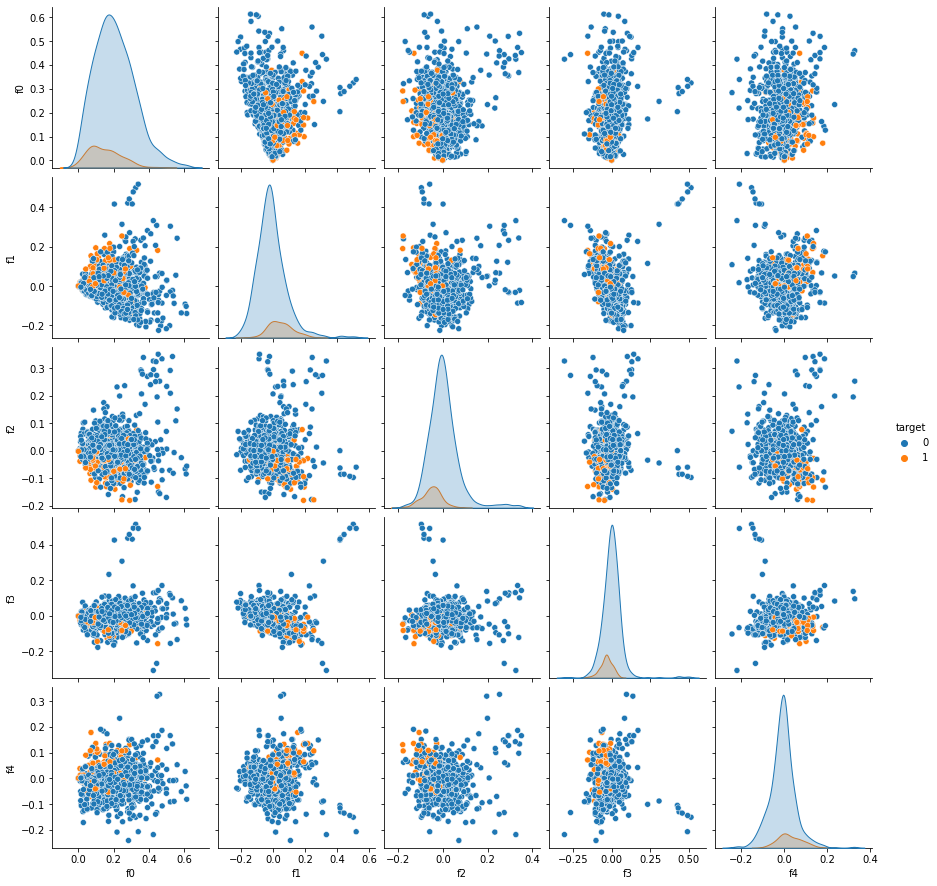

In [42]:
n_components = 5

plot_data = pd.DataFrame(X_svd[:1000, :n_components], columns=['f{}'.format(i) for i in range(n_components)])
plot_data['target'] = target[:1000]
sns.pairplot(plot_data, hue='target')

# Text preprocessing low-level code

In [43]:
# tokenize
import nltk

tok_corpus = []
for sent in tqdm(corpus):
#     tok_corpus.append(nltk.word_tokenize(sent))
    tok_corpus.append(sent.split())

tok_corpus[:5]

<ipython-input-43-c183bdf1fbe4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sent in tqdm(corpus):


  0%|          | 0/159571 [00:00<?, ?it/s]

[['explanation',
  'why',
  'the',
  'edits',
  'made',
  'under',
  'my',
  'username',
  'hardcore',
  'metallica',
  'fan',
  'were',
  'reverted',
  'they',
  'weren',
  't',
  'vandalisms',
  'just',
  'closure',
  'on',
  'some',
  'gas',
  'after',
  'i',
  'voted',
  'at',
  'new',
  'york',
  'dolls',
  'fac',
  'and',
  'please',
  'don',
  't',
  'remove',
  'the',
  'template',
  'from',
  'the',
  'talk',
  'page',
  'since',
  'i',
  'm',
  'retired',
  'now',
  '89',
  '205',
  '38',
  '27'],
 ['d',
  'aww',
  'he',
  'matches',
  'this',
  'background',
  'colour',
  'i',
  'm',
  'seemingly',
  'stuck',
  'with',
  'thanks',
  'talk',
  '21',
  '51',
  'january',
  '11',
  '2016',
  'utc'],
 ['hey',
  'man',
  'i',
  'm',
  'really',
  'not',
  'trying',
  'to',
  'edit',
  'war',
  'it',
  's',
  'just',
  'that',
  'this',
  'guy',
  'is',
  'constantly',
  'removing',
  'relevant',
  'information',
  'and',
  'talking',
  'to',
  'me',
  'through',
  'edits',
  'ins

# Create dictionary

In [44]:
# count words
counter = {}
for sent in tqdm(tok_corpus):
    for word in sent:
        counter[word] = counter.get(word, 0) + 1

<ipython-input-44-c642a8023a86>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sent in tqdm(tok_corpus):


  0%|          | 0/159571 [00:00<?, ?it/s]

Text(0, 0.5, 'log(frequency)')

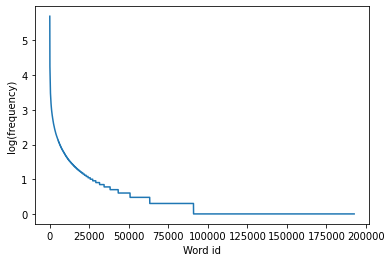

In [45]:

plt.plot(sorted([np.log10(v) for v in counter.values()], reverse=True))
plt.xlabel('Word id')
plt.ylabel('log(frequency)')

More than half of the words have frequency 1

In [46]:
# Make vocab
vocab = sorted(list(counter), key=counter.get,reverse=True)
print('Length:', len(vocab))
# Take only frequent words
min_count = 10
vocab = [word for word in vocab if counter[word] >= min_count]
print('Length:', len(vocab))
# Add <UNK> token
vocab.append('<UNK>')
print(vocab[:5])

# Make word index
word2idx = {word: idx for (idx, word) in enumerate(vocab)}
print(word2idx['the'], word2idx['to'], word2idx['hello'])

Length: 192588
Length: 27123
['the', 'to', 'i', 'of', 'and']
0 1 305


## Encode corpus

In [47]:
encoded_corpus = [[word2idx[word] for word in sent if word in word2idx] for sent in tqdm(tok_corpus)]
encoded_corpus[:5]

<ipython-input-47-bc99806a82fb>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  encoded_corpus = [[word2idx[word] for word in sent if word in word2idx] for sent in tqdm(tok_corpus)]


  0%|          | 0/159571 [00:00<?, ?it/s]

[[680,
  76,
  0,
  129,
  132,
  179,
  30,
  667,
  4474,
  11422,
  1089,
  86,
  333,
  49,
  2254,
  21,
  11423,
  53,
  6842,
  14,
  61,
  2736,
  149,
  2,
  2926,
  35,
  120,
  1189,
  15156,
  2787,
  4,
  46,
  60,
  21,
  245,
  0,
  361,
  32,
  0,
  38,
  29,
  145,
  2,
  69,
  3382,
  89,
  3055,
  4564,
  2255,
  975],
 [165,
  16435,
  51,
  2621,
  12,
  550,
  3777,
  2,
  69,
  4525,
  2696,
  22,
  95,
  38,
  795,
  2652,
  981,
  581,
  8364,
  184],
 [408,
  419,
  2,
  69,
  136,
  13,
  251,
  1,
  75,
  312,
  9,
  19,
  53,
  8,
  12,
  596,
  7,
  2269,
  489,
  498,
  103,
  4,
  605,
  1,
  37,
  326,
  129,
  360,
  3,
  30,
  38,
  29,
  51,
  212,
  1,
  430,
  59,
  39,
  0,
  2379,
  93,
  0,
  729,
  464],
 [59,
  2,
  36,
  21,
  98,
  56,
  327,
  1425,
  14,
  2091,
  2,
  5994,
  23,
  0,
  125,
  2479,
  58,
  15,
  508,
  14,
  26,
  6,
  4214,
  3,
  1306,
  3,
  9629,
  2,
  68,
  0,
  276,
  85,
  124,
  13239,
  40,
  8,
  49,
  18,
  4

## Load word2vec

In [50]:
import gensim

w2v_google = gensim.models.KeyedVectors.load_word2vec_format("../google/GoogleNews-vectors-negative300.bin", binary=True)

In [51]:
vec = w2v_google['hello']
print(type(vec))
print(vec.shape)

<class 'numpy.ndarray'>
(300,)


In [52]:
w2v_google.most_similar([vec])

[('hello', 1.0),
 ('hi', 0.6548984050750732),
 ('goodbye', 0.6399056315422058),
 ('howdy', 0.6310956478118896),
 ('goodnight', 0.5920578241348267),
 ('greeting', 0.5855877995491028),
 ('Hello', 0.5842196345329285),
 ("g'day", 0.5754078030586243),
 ('See_ya', 0.5688871741294861),
 ('ya_doin', 0.5643119812011719)]

In [53]:
w2v_google.most_similar(['hello'])

[('hi', 0.6548984050750732),
 ('goodbye', 0.6399056315422058),
 ('howdy', 0.6310956478118896),
 ('goodnight', 0.5920578241348267),
 ('greeting', 0.5855877995491028),
 ('Hello', 0.5842196345329285),
 ("g'day", 0.5754078030586243),
 ('See_ya', 0.5688871741294861),
 ('ya_doin', 0.5643119812011719),
 ('greet', 0.5636604428291321)]

In [57]:
w2v_google.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [58]:
w2v_google.most_similar(positive=['father', 'woman'], negative=['man'])

[('mother', 0.8462507128715515),
 ('daughter', 0.7899606823921204),
 ('husband', 0.7560455799102783),
 ('son', 0.7279756665229797),
 ('eldest_daughter', 0.7120417952537537),
 ('niece', 0.7096832990646362),
 ('aunt', 0.6960803866386414),
 ('grandmother', 0.689734160900116),
 ('sister', 0.6895190477371216),
 ('daughters', 0.6731119155883789)]

**Task:** try to get word "moscow" using the same principle

In [59]:
# YOUR CODE HERE
# w2v_google.most_similar(positive=['...', '...'], negative=['...'])

Check consistency with our corpus

In [60]:
w2v_google.most_similar(['fuck'])

[('fucking', 0.8137823343276978),
 ('f_*_ck', 0.801154613494873),
 ('f_**_k', 0.7815893888473511),
 ('shit', 0.7604621648788452),
 ('fucked', 0.7501130700111389),
 ('fuckin', 0.7309141755104065),
 ('f_***', 0.7172754406929016),
 ('f_ck', 0.7121477127075195),
 ('f_---', 0.7099311947822571),
 ('Fuck', 0.7066987156867981)]

In [61]:
w2v_google.most_similar(['ass'])

[('butt', 0.7703798413276672),
 ('azz', 0.7068755626678467),
 ('shit', 0.7049617171287537),
 ('asses', 0.6938721537590027),
 ('dick', 0.6921468377113342),
 ('hiney', 0.678607702255249),
 ('dude', 0.6721323728561401),
 ('d_*_ck', 0.6695902943611145),
 ('nads', 0.660144031047821),
 ('**_es', 0.6546863913536072)]

In [92]:
w2v_google.most_similar(['service'])

[('services', 0.6880398392677307),
 ('ser_vice', 0.6197038888931274),
 ('sevice', 0.5948099493980408),
 ('servce', 0.5434145927429199),
 ('serivce', 0.5427263975143433),
 ('service.The', 0.542389988899231),
 ('Service', 0.5327874422073364),
 ('sevices', 0.5212498903274536),
 ('servies', 0.5010811686515808),
 ('servic', 0.4864046573638916)]

## Train on word2vec bag of words

In [62]:
# Bag of words
X_w2v = [np.sum([np.zeros(vec.shape)] + [w2v_google[w] for w in sent if w in w2v_google], axis=0) for sent in tqdm(tok_corpus)]
normalize = lambda x: x / np.sqrt(np.sum(x**2) + 1e-8)
X_w2v = [normalize(x) for x in tqdm(X_w2v)]
X_w2v = np.array(X_w2v)
X_w2v.shape

<ipython-input-62-4431a9fcc61a>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_w2v = [np.sum([np.zeros(vec.shape)] + [w2v_google[w] for w in sent if w in w2v_google], axis=0) for sent in tqdm(tok_corpus)]


  0%|          | 0/159571 [00:00<?, ?it/s]

<ipython-input-62-4431a9fcc61a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_w2v = [normalize(x) for x in tqdm(X_w2v)]


  0%|          | 0/159571 [00:00<?, ?it/s]

(159571, 300)

In [63]:
%time eval_on_trainset(X_w2v[:1000], target[:1000])

Dummy accuracy: 0.895

KNN accuracy 0.924 +- 0.0074
KNN precision 0.707 +- 0.039
KNN recall 0.467 +- 0.0587
KNN f1 0.562 +- 0.0549
KNN roc_auc 0.854 +- 0.00758

Log regression accuracy 0.912 +- 0.0076
Log regression precision 0.933 +- 0.0943
Log regression recall 0.171 +- 0.0617
Log regression f1 0.286 +- 0.0891
Log regression roc_auc 0.935 +- 0.0146

SVM_linear accuracy 0.923 +- 0.00626
SVM_linear precision 0.645 +- 0.00941
SVM_linear recall 0.59 +- 0.105
SVM_linear f1 0.612 +- 0.062
SVM_linear roc_auc 0.927 +- 0.0172

SVM_rbf accuracy 0.93 +- 0.00868
SVM_rbf precision 0.72 +- 0.0682
SVM_rbf recall 0.562 +- 0.0943
SVM_rbf f1 0.624 +- 0.0578
SVM_rbf roc_auc 0.944 +- 0.0121

naive bayes accuracy 0.888 +- 0.0182
naive bayes precision 0.484 +- 0.0486
naive bayes recall 0.8 +- 0.0617
naive bayes f1 0.601 +- 0.0463
naive bayes roc_auc 0.911 +- 0.0188

random forest accuracy 0.915 +- 0.00626
random forest precision 0.917 +- 0.118
random forest recall 0.21 +- 0.0356
random forest f1 0.34 +- 0

In [64]:
%time eval_on_trainset(X_w2v[:10000], target[:10000], ['Log regression', 'random forest'])

Dummy accuracy: 0.9029

Log regression accuracy 0.94 +- 0.00075
Log regression precision 0.852 +- 0.025
Log regression recall 0.465 +- 0.0252
Log regression f1 0.601 +- 0.0151
Log regression roc_auc 0.95 +- 0.00245

random forest accuracy 0.929 +- 0.0026
random forest precision 0.93 +- 0.0153
random forest recall 0.29 +- 0.0348
random forest f1 0.441 +- 0.0379
random forest roc_auc 0.91 +- 0.00415

CPU times: user 43.2 s, sys: 587 ms, total: 43.8 s
Wall time: 42.2 s


1. # Word2vec visualization

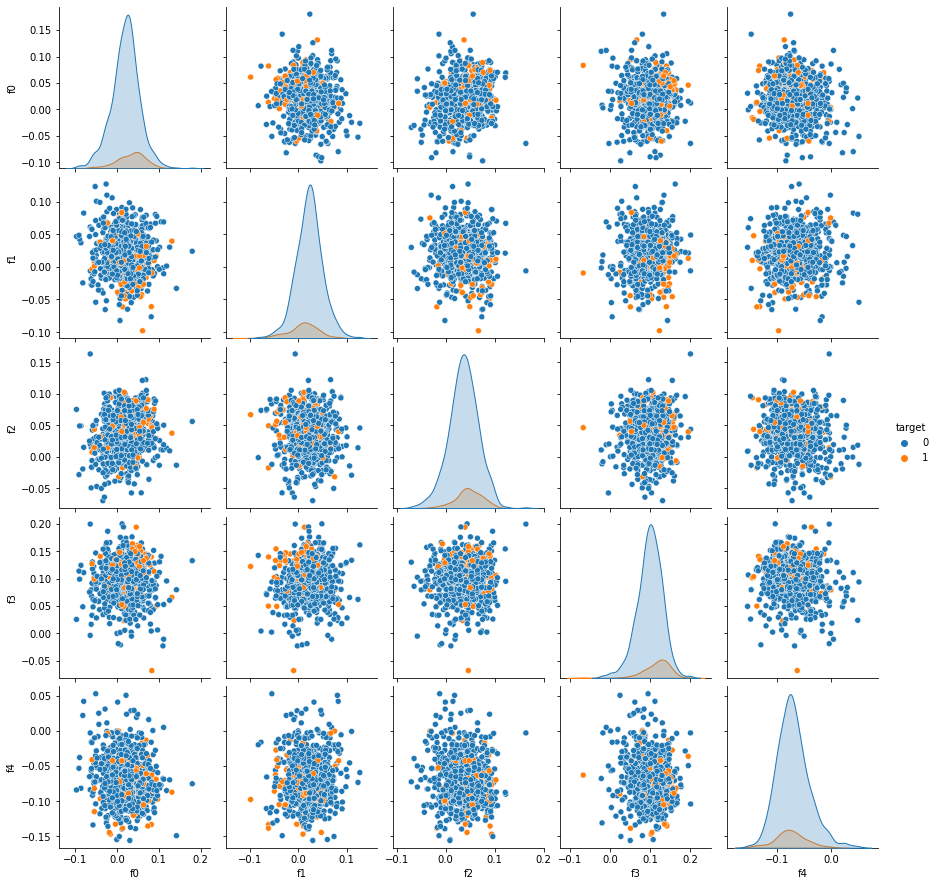

In [65]:
n_components = 5

plot_data = pd.DataFrame(X_w2v[:1000, :n_components], columns=['f{}'.format(i) for i in range(n_components)])
plot_data['target'] = target[:1000]
sns.pairplot(plot_data, hue='target')

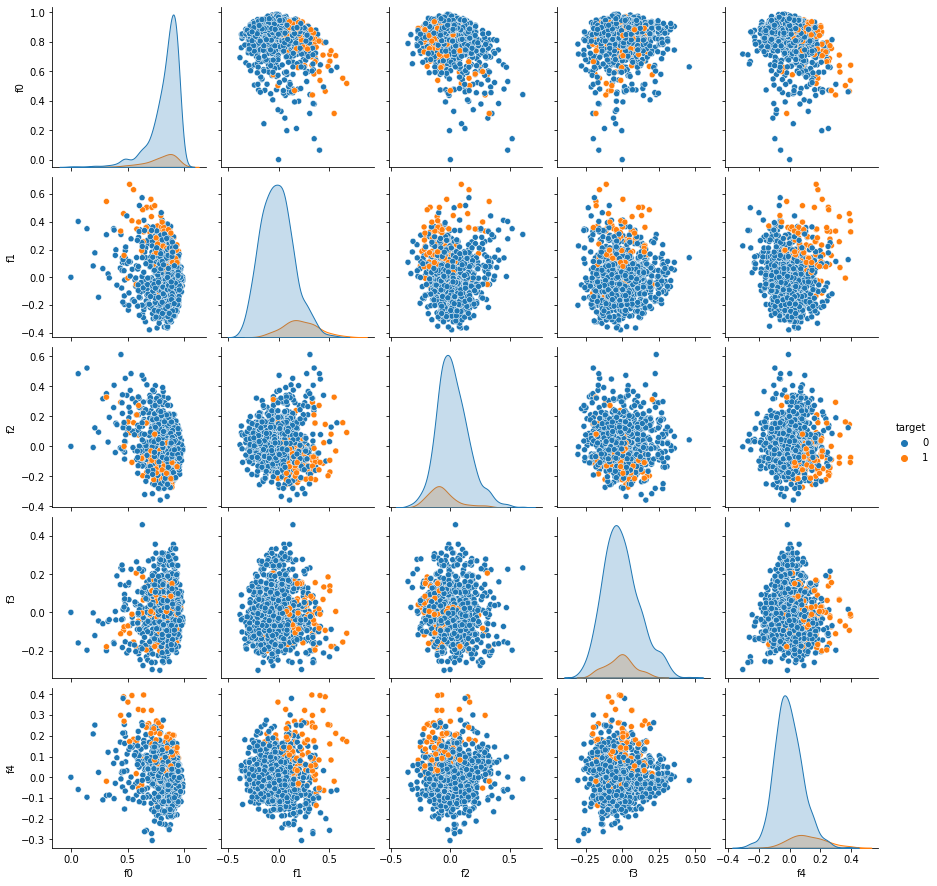

In [66]:
n_components = 5

plot_data = pd.DataFrame(TruncatedSVD(n_components=n_components).fit_transform(X_w2v)[:1000], columns=['f{}'.format(i) for i in range(n_components)])
plot_data['target'] = target[:1000]
sns.pairplot(plot_data, hue='target')

# KMeans Clustering

In [67]:
from sklearn.cluster import MiniBatchKMeans, MeanShift, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

In [68]:
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

dists = []
scores = []

for k in tqdm(range(2, 21)):
    kmeans = MiniBatchKMeans(k)
    kmeans.fit(X_w2v)
    centers = kmeans.cluster_centers_
    labels = kmeans.predict(X_w2v)
    # Mean squared distance
    mean_dist = np.sum([distance(x, centers[label])**2 for x, label in zip(X_w2v, labels)])
    dists.append(mean_dist)
    # Silhouette
    score = silhouette_score(X_w2v[:2000], labels[:2000], metric='euclidean')
    scores.append(score)

<ipython-input-68-ba9b99d366b8>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(2, 21)):


  0%|          | 0/19 [00:00<?, ?it/s]

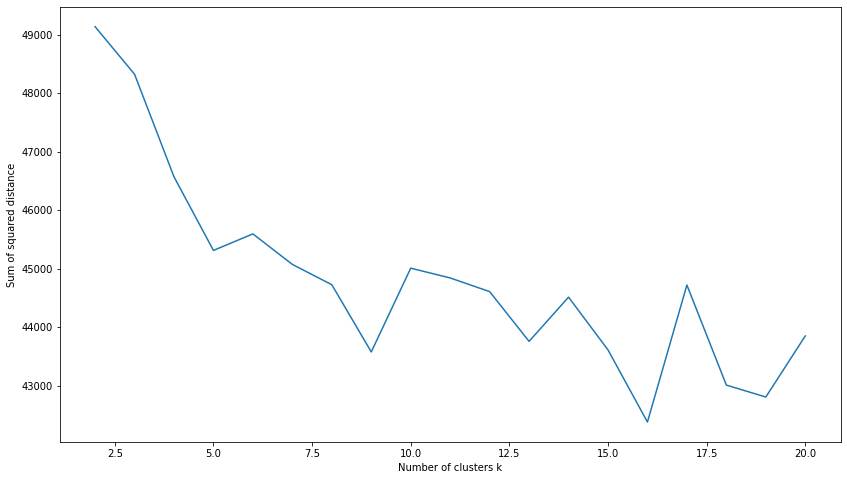

In [69]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(2, 21), dists)
plt.ylabel('Sum of squared distance')
plt.xlabel('Number of clusters k')
plt.show()

Elbow can be considered at k value from 3 to 6.

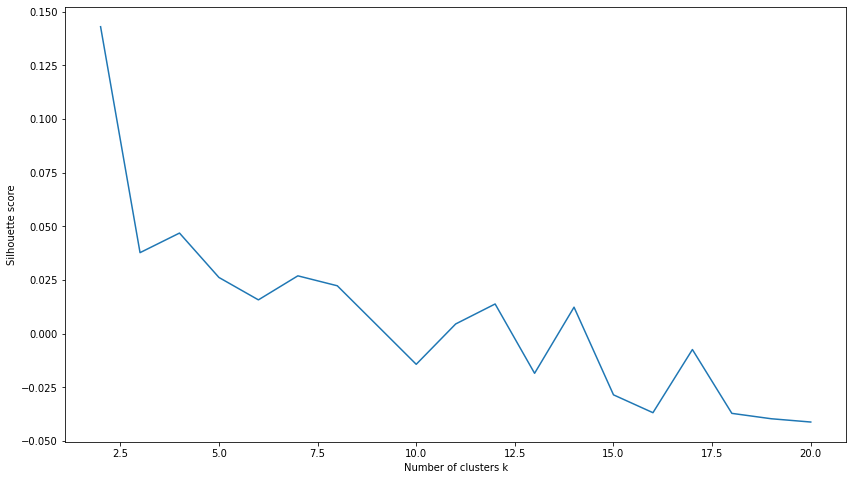

In [70]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(2, 21), scores)
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters k')
plt.show()

In [71]:
k = 7
kmeans = MiniBatchKMeans(k, random_state=2)
kmeans.fit(X_w2v)
train['KMeans'] = kmeans.predict(X_w2v)

In [72]:
kmeans.predict(X_w2v)

array([6, 4, 6, ..., 0, 6, 6], dtype=int32)

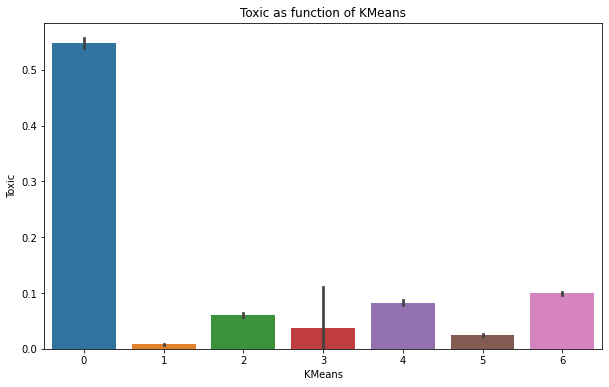

In [73]:
plt.subplots(figsize=(10,6))
sns.barplot(x='KMeans' , y='toxic' , data=train)
plt.ylabel("Toxic")
plt.title("Toxic as function of KMeans")
plt.show()

In [74]:
# Find the most toxic sentence
am = np.argmin(np.sum((X_w2v - kmeans.cluster_centers_[0].reshape([1, 300]))**2, axis=1))
corpus[am]

'our previous conversation you fucking shit eating liberal you make lady bird johnson shake on her tampon i said fucking sorry for my little brother and you still had to fucking complain my life is fucking shit my mother is always yelling at me and my dad beats the shit out of me if i get fucking out of line my brother s one outlet is wikipedia he cried when he saw my father smacking me and his tears clogged his mac book pro s keyboard we had to go to fucking apple and get a new one all out of my mom s pocket then last night i wanted to take this hot pussy from connecticut out in my dad s new rolls royce and he said fucking no so you know what i fucking did i fucking cut his pinky off and didnt snitch like a little bitch like you i take lazy ass niggers like you and stomp you with my fat nazi heel you should be fucking sorry you ever fucked with me or my dad steve jobs and if i find out your using linux i ll take pity on thee cause you re just too stupid to understand shit i can see yo

In [75]:
# Find the least toxic sentence
am = np.argmin(np.sum((X_w2v[target == 1] - kmeans.cluster_centers_[1].reshape([1, 300]))**2, 1))
corpus[target == 1].iloc[am]

'i didn t initiate the attacks just responded to them in turn calling them nuts was euphemistic i could have called them turkeys as well obviously wikipedia is the encyclopedia only people with proprietary interest in an article can edit you re part of the problem underwood had an effect on the church or at bare minimum is an in joke therefore there should be mention of him in the article i can see your mind is made up though so i ll save my breath there s no point having integrity when surrounded by folks determined to enforce their bias and other folks too busy to research the subject properly it took you several minutes to research hundreds of posts and relationships between church members and underwood i m done your arrogance is plain as day i didn t claim to have made a perfect edit i even suggested re editing in the talk page however underwood s effect is plain as day and as such should be mentioned the reason i m leery of the custodians of the page is because in adding the bob b

In [76]:
k = 7
kmeans = MiniBatchKMeans(k, random_state=0)
kmeans.fit(X_svd)
train['KMeans_SVD'] = kmeans.predict(X_svd)

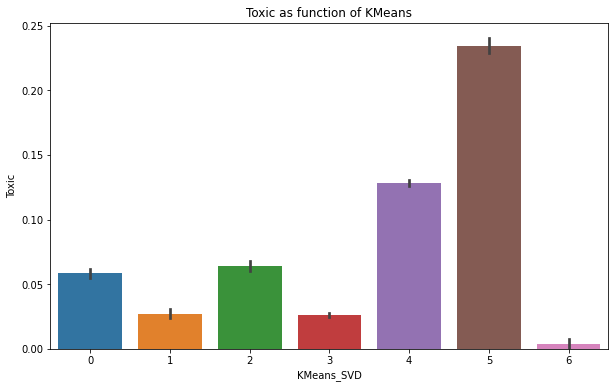

In [77]:
plt.subplots(figsize=(10,6))
sns.barplot(x='KMeans_SVD' , y='toxic' , data=train)
plt.ylabel("Toxic")
plt.title("Toxic as function of KMeans")
plt.show()

In [78]:
# Find the most toxic sentence
am = np.argmin(np.sum((X_svd - kmeans.cluster_centers_[0].reshape([1, 100]))**2, 1))
corpus[am]

'cossde royalists from kurunduwatte colombo 7 and rajakeeya maha vidyalaya colombo 7 cossde we are not so desparate about your so called wikipedia to show the world our colleges or it s old boys etc we do have our own college web sites do it cossde can down grade delete demand references for each an every word make all colleges in sri lanka except the prestigious royal college colombo 7 to vidyalaya or maha vidyalaya as you wish except for the prestigious rajakeeya maha vidyalaya or royal college royalists from other royal colleges in sri lanka ie royal college polonnaruwa can speak english too if you think that only the royal college colombo 7 be the only college in sri lanka and thurstan college colombo 7 situated just adjoining royal college to be deleted immediately saying it is vandalism you are badly mistaken you are a sick person show your royal college colombo 7 kurunduwatte colours to the whole world it is just like claiming as if you have captured medawatchchiya not knowing w

Prediction based entirely on one cluster:

In [79]:
preds = (train['KMeans'] == 0).astype('int')
print('accuracy', accuracy_score(preds, target))
print('precision', precision_score(target, preds))
print('recall', recall_score(target, preds))
print('f1', f1_score(target, preds))

accuracy 0.9116756804181211
precision 0.5482470247668061
recall 0.4457957368902838
f1 0.49174179588892897


In [80]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,KMeans,KMeans_SVD
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,6,4
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,4,4
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,6,2
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,6,3
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,6,5
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,5,4
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,4
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,5,5
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,6,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1,4


# MeanShift

In [81]:
%%time
meanshift = MeanShift(bandwidth=0.9)
meanshift.fit(X_w2v[:1000])

CPU times: user 24 s, sys: 15.2 s, total: 39.3 s
Wall time: 11.1 s


MeanShift(bandwidth=0.9)

In [82]:
train['MeanShift'] = meanshift.predict(X_w2v)
print(len(train['MeanShift'].unique()))

19


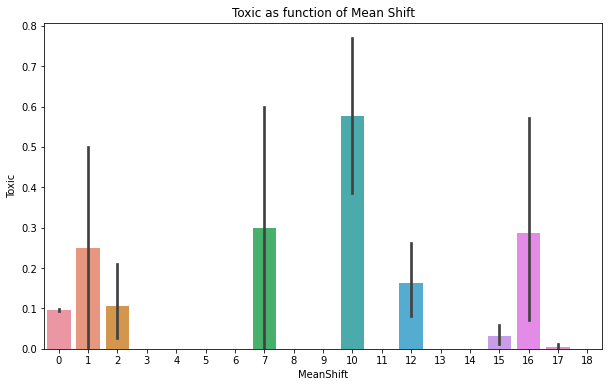

In [83]:
plt.subplots(figsize=(10,6))
sns.barplot(x='MeanShift' , y='toxic' , data=train)
plt.ylabel("Toxic")
plt.title("Toxic as function of Mean Shift")
plt.show()

In [84]:
preds = (train['MeanShift'] == 10).astype('int')
print('accuracy', accuracy_score(preds, target))
print('precision', precision_score(target, preds))
print('recall', recall_score(target, preds))
print('f1', f1_score(target, preds))

accuracy 0.904180584191363
precision 0.5769230769230769
recall 0.000980776775205963
f1 0.0019582245430809398


## Gaussian Mixture

In [85]:
k = 7
gmix = GaussianMixture(k, random_state=2)
%time gmix.fit(X_w2v[:10000])
train['GMixture'] = gmix.predict(X_w2v)

CPU times: user 1min 48s, sys: 23.1 s, total: 2min 11s
Wall time: 36.4 s


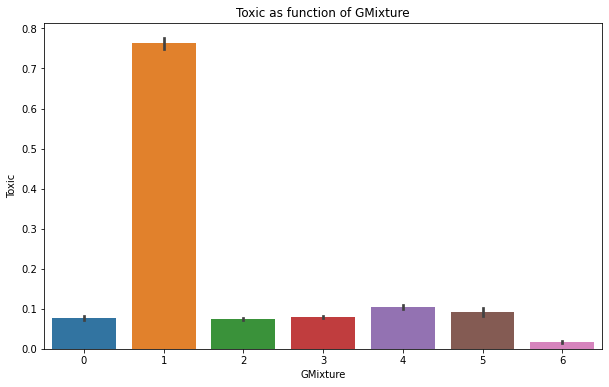

In [86]:
plt.subplots(figsize=(10,6))
sns.barplot(x='GMixture' , y='toxic' , data=train)
plt.ylabel("Toxic")
plt.title("Toxic as function of GMixture")
plt.show()

In [87]:
preds = (train['GMixture'] == 1).astype('int')
print('accuracy', accuracy_score(preds, target))
print('precision', precision_score(target, preds))
print('recall', recall_score(target, preds))
print('f1', f1_score(target, preds))

accuracy 0.920198532314769
precision 0.7627257799671593
recall 0.2429710997776906
f1 0.36854110879698504


# Try to train models on clusters

In [88]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,KMeans,KMeans_SVD,MeanShift,GMixture
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,6,4,0,4
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,4,4,0,5
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,6,2,0,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,6,3,0,3
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,6,5,0,1


In [89]:
n_cluterizers = 4

train_cl = train.iloc[:, -n_cluterizers:]
for cl in train_cl.columns:
    print(cl, train_cl[cl].unique())
    for i in sorted(train_cl[cl].unique()):
        train_cl[cl + '_%i' % i] = (train_cl[cl] == i).astype(int)
train_cl = train_cl.iloc[:, n_cluterizers:]
train_cl.head()

KMeans [6 4 5 0 1 2 3]
KMeans_SVD [4 2 3 5 0 6 1]
MeanShift [ 0  8  4  2 17  1  5 14  6 18  3 11 12  9 10  7 15 16 13]
GMixture [4 5 3 1 0 6 2]


,KMeans_0,KMeans_1,KMeans_2,KMeans_3,KMeans_4,KMeans_5,KMeans_6,KMeans_SVD_0,KMeans_SVD_1,KMeans_SVD_2,...,MeanShift_16,MeanShift_17,MeanShift_18,GMixture_0,GMixture_1,GMixture_2,GMixture_3,GMixture_4,GMixture_5,GMixture_6
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [90]:
%time eval_on_trainset(train_cl.iloc[:10000, :], target[:10000])

Dummy accuracy: 0.9029

KNN accuracy 0.904 +- 0.0157
KNN precision 0.58 +- 0.139
KNN recall 0.341 +- 0.13
KNN f1 0.392 +- 0.0982
KNN roc_auc 0.741 +- 0.0281

Log regression accuracy 0.92 +- 0.00134
Log regression precision 0.646 +- 0.0231
Log regression recall 0.389 +- 0.0237
Log regression f1 0.485 +- 0.0134
Log regression roc_auc 0.848 +- 0.00419

SVM_linear accuracy 0.919 +- 0.00222
SVM_linear precision 0.626 +- 0.0266
SVM_linear recall 0.422 +- 0.0223
SVM_linear f1 0.503 +- 0.0129
SVM_linear roc_auc 0.775 +- 0.0187

SVM_rbf accuracy 0.92 +- 0.0012
SVM_rbf precision 0.644 +- 0.0199
SVM_rbf recall 0.404 +- 0.0268
SVM_rbf f1 0.495 +- 0.0159
SVM_rbf roc_auc 0.742 +- 0.0146

naive bayes accuracy 0.119 +- 0.0148
naive bayes precision 0.0989 +- 0.0017
naive bayes recall 0.995 +- 0.00146
naive bayes f1 0.18 +- 0.00284
naive bayes roc_auc 0.567 +- 0.0886

random forest accuracy 0.92 +- 0.00134
random forest precision 0.641 +- 0.0229
random forest recall 0.408 +- 0.0281
random forest f1 0.49